# Imports / Config

In [1]:
import os
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Utils

In [2]:
import numpy as np
import spacy

nlp = spacy.load('en_core_web_lg')


def classify_from_keywords(text, classifications_and_keywords):
    """
    Maps text to classification based on its containing a keyword. A *very* basic implementation,
    it returns only one classification to describe text which is determined by the
    last-detected keyword. This works fine if classifications are mutually exclusive
    but not well otherwise.
    
    Keyword arguments:
    text -- text to search for keywords (string)
    classifications_and_keywords -- classifications and associated keywords in the
        format {'classification':['kw1', 'kw2', 'kw3, ...] (dictionary)
        
    Returns:
    string - text's classification
    """
    for classification, keywords in classifications_and_keywords.items():
        for keyword in keywords:
            if keyword in text:
                return classification
    return None


def gen_text_embeddings(texts, propn_weight=1.0):
    """
    Forms real-number-vector embeddings to represent a set of documents. This is 
    achieved by iterating through each token in each text, using spacy to generate a word embedding for it, 
    and then averaging the word embeddings.
    
    Keyword arguments:
    texts - texts to generate embeddings for (list or df column of string)
    propn_weight - the weight to assign proper nouns in averaging (1.0 = same as other parts of
        speech) (float)
        
    Returns:
    numpy array - text embeddings
    """
    n_texts = len(texts)
    embedding_dimensions = len(nlp(texts[0]).vector)
    texts_embeddings = np.zeros((n_texts, embedding_dimensions))

    for i in np.arange(0, n_texts):
        text = texts[i]
        if text != '':
            token_embeddings = []
            token_weights = []
            for token in nlp(text, disable=['parser', 'ner']):
                token_embeddings.append(token.vector)
                token_weights += [propn_weight if token.pos_ == 'PROPN' else 1.0]
            if sum(token_weights) > 0:
                text_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
                texts_embeddings[i] = text_embedding
    
    return texts_embeddings


def lemmatize(text, pos_to_keep=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'], 
              override_pos_filter=False, single_str_output=True):
    """
    Decomposes text into lemma tokens.
    
    Keyword arguments:
    text - text to decompose  (string)
    pos_to_keep - spacy-abbreviated part-of-speech types; a word's lemma will only appear
        in output if it is one of these types (list of strings, default: ['NOUN', 'PROPN',
        'VERB', 'ADJ', 'ADV'])
    override_pos_filter - if True, pos_to_keep is ignored and all parts of speech are kept
        (boolean, default: False)
    single_str_output - if True, output lemmas as a single string; if False, output lemmas as a 
        list of strings (boolean, default: True)
        
    Returns:
    string or list of strings - text in lemmatized form
    
    """
    doc = nlp(text, disable=['parser', 'ner'])
    lemmas = [
        token.lemma_ for token in doc
        if (not token.is_stop
            and (token.pos_ in pos_to_keep
                 or override_pos_filter))
    ]
    if single_str_output:
        lemmas = ' '.join(lemmas)

    return lemmas


def subset(df, colnames, values):
    """
    Subsets a df to only those documents where colnames == values.
    
    Keyword arguments:
    df - dataframe to subset (pandas DataFrame)
    colnames - names of df columns whose values to compare (list of strings)
    values - values to compare with those in df columns (list)
    
    Returns:
    pandas DataFramd - subset of df
    """
    filt = np.ones(len(df), dtype=bool)
    for colname, value in zip(colnames, values):
        filt = (filt & (df[colname] == value))

    subset = df[filt].copy().reset_index()
    subset.drop(labels=['index'], axis='columns', inplace=True)

    return subset


def vectors_and_vocab(texts, vectorizer):
    """
    Decomposes texts into word-vector matrix and vocabulary.
    
    Keyword arguments:
    texts - documents, sub-documents or collections to vectorize (list of strings)
    vectorizer - a vectorizer from sklearn.feature_extraction.text (class)
    
    Returns:
    sparse array - texts in vectorized form
    list of string - texts' vocabulary
    """
    matrix = vectorizer.fit_transform(texts)
    vocab = vectorizer.get_feature_names()

    return matrix, vocab


# Collection

In [3]:
from datetime import datetime, timedelta
from dateutil.parser import parse as timeparse
import pandas as pd
import psycopg2
from pymongo import MongoClient

import configs

#MongoDB Config
mdb_client = MongoClient(configs.MDB_HOST)
milli_mdb = mdb_client.milli_mdb
parsed_content = milli_mdb.parsed_content


def get_cluster_training_corpus(sample_size):
    """
    Gets a randomized sample of document-clusters from the UCI news aggregator dataset
    of a given size. 
    UCI news dataset: https://archive.ics.uci.edu/ml/datasets/News+Aggregator

    Keyword arguments:
    sample_size - number of documents to return (integer)
    
    
    Returns:
    pandas DataFrame - clustered documents; each row is a document and columns are
        ['title', 'url', 'training_cluster_id', 'rnd']
    """
    sql = """
        WITH
        stories as (
            SELECT distinct
            story

            FROM uci_news_dataset
        ),

        randomized_stories as (
            SELECT
            story,
            random() as rnd

            FROM stories
        )

        SELECT
        und.title,
        und.url,
        und.story AS training_cluster_id,
        rs.rnd

        FROM uci_news_dataset und
        JOIN randomized_stories rs
            on rs.story = und.story

        ORDER BY 4

        LIMIT %s
    """
    pg_conn = psycopg2.connect(host=configs.PG_HOST,
                           dbname=configs.PG_DBNAME,
                           user=configs.PG_USER,
                           password=configs.PG_PASSWORD)
    pg_cursor = pg_conn.cursor()
    pg_cursor.execute(sql, (sample_size,))
    cluster_training_corpus = pg_cursor.fetchall()
    pg_cursor.close()
    pg_conn.close()

    cluster_training_corpus = pd.DataFrame(
        cluster_training_corpus,
        columns=['title', 'url', 'training_cluster_id', 'rnd']
    )
    return cluster_training_corpus


def get_publisher_feeds():
    """
    Gets publisher feeds from PostgreSQL and classifies each by region and topic.
    
    Keyword arguments:
    None
    
    Returns:
    pandas DataFrame - publisher feeds; each row is a feed and columns are:
        ['publisher', 'subcategory', 'feed_url', 'local_classification', 
        'region_classification', 'topic_classifiation]
    """
    sql = """
        SELECT
        publisher,
        subcategory,
        url AS feed_url,
        'Local - '||city_id as local_classification

        FROM feeds
    """
    pg_conn = psycopg2.connect(host=configs.PG_HOST,
                           dbname=configs.PG_DBNAME,
                           user=configs.PG_USER,
                           password=configs.PG_PASSWORD)
    pg_cursor = pg_conn.cursor()
    pg_cursor.execute(sql)
    feeds = pg_cursor.fetchall()
    pg_cursor.close()
    pg_conn.close()

    feeds = pd.DataFrame(
        feeds,
        columns=['publisher', 'subcategory', 'feed_url', 'local_classification']
    )

    feeds['region_classification'] = feeds['subcategory'].apply(
        lambda x: classify_from_keywords(x.lower(),
                                         configs.REGION_CLASSIFICATIONS_AND_KEYWORDS)
    )
    feeds['region_classification'] = (
        feeds['local_classification'].combine_first(feeds['region_classification'])
    )
    feeds['topic_classification'] = feeds['subcategory'].apply(
        lambda x: classify_from_keywords(x.lower(),
                                         configs.TOPIC_CLASSIFICATIONS_AND_KEYWORDS)
    )

    return feeds


def get_recently_crawled_content(days_of_content=7):
    """
    Gets data and metadata of recently-crawled (by Milli) publisher content from MongoDB.
    
    Keyword arguments:
    days_of_content - days of recent content to pull, from days_of_content days ago 
        until now (integer)
    
    Returns:
    pandas DataFrame - rows are publisher articles and columns are
        ['url', 'crawled_timestamp', 'title', 'feed_url', 'meta_keywords', 'text', 'title_language']
    
    """
    start_timestamp = str(datetime.utcnow()
                          - timedelta(days=days_of_content))

    recent_content_cursor = parsed_content.find(
        {'crawled_timestamp':{'$gt':start_timestamp},
         'title_language':'en'}
    )
    to_concat = []
    for doc in recent_content_cursor:
        record = pd.DataFrame({
            'url':[doc['url']],
            'crawled_timestamp':[timeparse(doc['crawled_timestamp'])],
            'title':[doc['title']],
            'feed_url':[doc['feed_url']],
            'meta_keywords':[' '.join(doc['meta_keywords'])],
            'text':[doc['text']],
            'title_language':[doc['title_language']],
        })
        to_concat.append(record)
    recent_content = pd.concat(to_concat).reset_index()
    recent_content['text_word_count'] = (
        recent_content['text'].apply(lambda x: len(x.split()))
    )
    recent_content.drop(labels=['index'], axis='columns', inplace=True)

    return recent_content


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Classification

In [4]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

#TODO: reduce memory load here?
def svm_extrapolate_classification(df, feature_matrix, classification_colname,
                                   verbose=False):
    """
    Given a df where some documents are classified (exclusively), trains a SVM classifier
    on the classified subset and then makes predictions for the entire df.
    
    Keyword arguments:
    df - dataset to be classified (pandas DataFrame)
    feature_matrix - vectorized features for classification training/fitting  (numpy array)
    classification_colname - name of dependent variable (string)
    
    Returns:
    pandas DataFrame - df with [classification_colname]_predicted and 
        [classification_colname]_probability columns added.
    
    """
    df_ = df.copy()
    feature_matrix_ = feature_matrix.copy()
    filt = (~df_[classification_colname].isna())
    y = df_[filt][classification_colname].copy()
    indexes = np.where(filt)
    X = feature_matrix_[indexes].copy()
    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.2)
    )

    sgd = SGDClassifier(
        max_iter=10,
        n_jobs=2,
        loss='modified_huber',
        learning_rate='optimal',
        penalty='elasticnet',
        alpha=0.0001,
        l1_ratio=0.5,
    )
    sgd.fit(X_train, y_train)

    if verbose:
        pred = sgd.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, pred)
        print("accuracy:   %0.3f" % accuracy)
        print()
        print("classification report:")
        print(metrics.classification_report(y_test, pred))
        print()
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    df_[classification_colname+'_predicted'] = (
        sgd.predict(feature_matrix_)
    )
    df_[classification_colname+'_probability'] = (
        np.exp(sgd.predict_log_proba(feature_matrix_)).max(axis=1)
    )

    return df_

# Corpus

In [5]:
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer

# from collection import get_publisher_feeds, get_recently_crawled_content
# from classification import svm_extrapolate_classification
# from utils import subset, vectors_and_vocab


class Corpus(object):
    """
    
    Keyword arguments:

    """
    def __init__(self, df=None, publisher_feeds=get_publisher_feeds(),
                 days_of_recent_content=7, verbose=False):
        if df is None:
            df = get_recently_crawled_content(days_of_recent_content)
            df = df.merge(
                publisher_feeds[['feed_url',
                                      'region_classification',
                                      'topic_classification']],
                how='left'
            )
            self.df = df
        else:
            self.df = df
        self.publisher_feeds = publisher_feeds
        self.days_of_recent_content = days_of_recent_content
        self.verbose = verbose

        self.titles_tfidf_matrix = None
        self.titles_tfidf_vocab = None
        self.texts_tfidf_matrix = None
        self.texts_tfidf_vocab = None
        self.meta_keywords_tfidf_matrix = None
        self.meta_keywords_tfidf_vocab = None
        self.master_tfidf_matrix = None
        self.master_tfidf_vocab = None


    def vectorize(self):
        """
    
        Keyword arguments:

        """
        tfidf_vectorizer = TfidfVectorizer(
            ngram_range=(1, 2), stop_words='english', min_df=2, max_df=0.5
        )
        self.titles_tfidf_matrix, self.titles_tfidf_vocab = (
            vectors_and_vocab(list(self.df['title']), tfidf_vectorizer)
        )
        self.texts_tfidf_matrix, self.texts_tfidf_vocab = (
            vectors_and_vocab(list(self.df['text']), tfidf_vectorizer)
        )
        self.meta_keywords_tfidf_matrix, self.meta_keywords_tfidf_vocab = (
            vectors_and_vocab(list(self.df['meta_keywords']), tfidf_vectorizer)
        )
        self.master_tfidf_matrix = hstack(
            [self.titles_tfidf_matrix, self.texts_tfidf_matrix, self.meta_keywords_tfidf_matrix]
        ).tocsr()
        self.master_tfidf_vocab = (
            self.titles_tfidf_vocab + self.texts_tfidf_vocab + self.meta_keywords_tfidf_vocab
        )


    def classify(self):
        """
    
        Keyword arguments:

        """
        self.df = svm_extrapolate_classification(
            self.df,
            self.master_tfidf_matrix,
            classification_colname='topic_classification',
            verbose=self.verbose
        )
        self.df = svm_extrapolate_classification(
            self.df,
            self.master_tfidf_matrix,
            classification_colname='region_classification',
            verbose=self.verbose
        )

    
    def enqueue_clustering(self):
        """
    
        Keyword arguments:

        """
        print('subsetting content...')
        subset_colnames = ['topic_classification_predicted']
        subset_values = ['Politics, Policy & Economics']
        df_subset = subset(self.df, subset_colnames, subset_values)
        
        l1_cluster(df_subset, 'title', self.verbose)

In [6]:
%%time
recent_content_corpus = Corpus(days_of_recent_content=7, verbose=True)

CPU times: user 2min 20s, sys: 6.75 s, total: 2min 27s
Wall time: 5min 31s


In [7]:
%%time
recent_content_corpus.vectorize()

CPU times: user 3min 16s, sys: 7.55 s, total: 3min 23s
Wall time: 3min 25s


In [8]:
%%time
recent_content_corpus.classify()

accuracy:   0.886

classification report:
                                precision    recall  f1-score   support

 Entertainment, Culture & Arts       0.86      0.94      0.90       674
            Finance & Business       0.77      0.78      0.78       455
  Politics, Policy & Economics       0.84      0.88      0.86       254
                        Sports       0.98      0.99      0.98      1304
Technology, Science & Medicine       0.69      0.50      0.58       198
      Travel, Lifestyle & Food       0.85      0.68      0.76       213

                   avg / total       0.88      0.89      0.88      3098


confusion matrix:
[[ 634   13    9   12    0    6]
 [  25  356   19    8   35   12]
 [   9   14  224    0    5    2]
 [  13    3    1 1287    0    0]
 [  18   67    8    1   99    5]
 [  39   10    5    9    5  145]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


accuracy:   0.936

classification report:
                      precision    recall  f1-score   support

          Asia & ANZ       0.99      0.90      0.94       181
              Europe       0.85      0.72      0.78        76
       Latin America       1.00      0.20      0.33        10
           Local - 1       0.92      0.99      0.95      2957
          Local - 10       0.95      0.93      0.94      1985
Middle East & Africa       1.00      0.78      0.88        81
       U.S. & Canada       0.93      0.70      0.80       405

         avg / total       0.94      0.94      0.93      5695


confusion matrix:
[[ 162    5    0    6    6    0    2]
 [   1   55    0   10    8    0    2]
 [   0    1    2    7    0    0    0]
 [   0    0    0 2913   31    0   13]
 [   0    0    0  136 1848    0    1]
 [   0    1    0    7    8   63    2]
 [   0    3    0   77   40    0  285]]
CPU times: user 45 s, sys: 2.6 s, total: 47.6 s
Wall time: 31.7 s


# Clustering

In [9]:
recent_content_corpus.df.region_classification_predicted.value_counts()

Local - 1               65824
Local - 10              34380
U.S. & Canada           20097
Asia & ANZ               3394
Europe                   2695
Middle East & Africa      850
Latin America              99
Name: region_classification_predicted, dtype: int64

In [10]:
recent_content_corpus.df.topic_classification_predicted.value_counts()

Entertainment, Culture & Arts     43756
Sports                            28553
Finance & Business                23434
Politics, Policy & Economics      18472
Travel, Lifestyle & Food           8039
Technology, Science & Medicine     5085
Name: topic_classification_predicted, dtype: int64

In [53]:
subset_colnames = ['topic_classification_predicted', 'region_classification_predicted']
subset_values = ['Politics, Policy & Economics', 'U.S. & Canada']
corpus = subset(recent_content_corpus.df, subset_colnames, subset_values)

In [54]:
text_colname = 'title'

In [201]:
%%time
cluster_training_corpus = get_cluster_training_corpus(int(len(corpus)*0.25))
training_cluster_ids_and_n_texts = {}
cluster_id_counts = cluster_training_corpus['training_cluster_id'].value_counts()
for cluster, ct in zip(cluster_id_counts.index, cluster_id_counts.values):
    training_cluster_ids_and_n_texts[cluster] = ct

CPU times: user 22.1 ms, sys: 13.1 ms, total: 35.1 ms
Wall time: 15.6 s


In [202]:
%%time
corpus_plus = pd.concat(
    [corpus, cluster_training_corpus],
    ignore_index=True
)
corpus_plus[text_colname+'_lemmatized'] = (
    corpus_plus[text_colname].apply(
        lambda x: lemmatize(x, pos_to_keep=['NOUN', 'PROPN'])
    )
)

CPU times: user 16 s, sys: 1.3 s, total: 17.3 s
Wall time: 14.5 s


In [203]:
len(corpus_plus)

5422

In [204]:
%%time
lemmatized_texts = corpus_plus[text_colname+'_lemmatized']
lemmatized_texts_embeddings = gen_text_embeddings(
    lemmatized_texts, propn_weight=1.3
    #^found that we get better fit if proper nouns upweighted @ 1.3
)

CPU times: user 14.4 s, sys: 998 ms, total: 15.4 s
Wall time: 13 s


## Scipy Method

In [220]:
from scipy.cluster.hierarchy import dendrogram, linkage as agglomerative_cluster

In [246]:
def gen_ac_tradeoff(ac_result, docs, story_ids_and_n_docs, nodes_to_process_between_plots=100, plot=False):
    docs_ = docs.copy()
    n_docs = len(docs_)
    
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)
    
    n_clusters = []
    avg_story_tc_recalls = []
    avg_story_tc_precisions = []
    avg_story_tc_f1_scores = []
    
    for n, clustering in enumerate(ac_result):
        idx = n + n_docs
        lc = clustering[0]
        rc = clustering[1]

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]
        
        for doc_id in cluster_doc_ids[idx]:
            doc_clusters[doc_id] = idx
        docs_['cluster'] = doc_clusters
        
        if idx % nodes_to_process_between_plots == 0:
            cluster_counts = docs_['cluster'].value_counts()

            story_tc_recalls = []
            story_tc_precisions = []
            story_weights = []
            for story_id, doc_count in story_ids_and_n_docs.items():
                filt = (docs_['training_cluster_id'] == story_id)
                story_cluster_counts = docs_[filt]['cluster'].value_counts()

                top_cluster_recall = story_cluster_counts.values[0] * 1.0 / doc_count
                top_cluster_precision = (
                    story_cluster_counts.values[0] * 1.0 / cluster_counts[story_cluster_counts.index[0]]
                )

                story_tc_recalls.append(top_cluster_recall)
                story_tc_precisions.append(top_cluster_precision)
                story_weights.append(doc_count)

            avg_story_tc_recall = np.average(story_tc_recalls, weights=story_weights)
            avg_story_tc_precision = np.average(story_tc_precisions, weights=story_weights)

            n_clusters.append(len(cluster_doc_ids))
            avg_story_tc_recalls.append(avg_story_tc_recall)
            avg_story_tc_precisions.append(avg_story_tc_precision)
            avg_story_tc_f1_scores.append(2.0/(1.0/avg_story_tc_recall + 1.0/avg_story_tc_precision))
        
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(n_clusters, avg_story_tc_recalls, label='Avg Story TC Recall')
        plt.plot(n_clusters, avg_story_tc_precisions, label='Avg Story TC Precision')
        plt.plot(n_clusters, avg_story_tc_f1_scores, label='Avg Story TC F1 Scores')
        plt.legend(loc='best')
        plt.show()
        plt.close()
    
    max_avg_story_tc_f1_scores = max(avg_story_tc_f1_scores)
    optimal_n_clusters = n_clusters[avg_story_tc_f1_scores.index(max_avg_story_tc_f1_scores)]
    
    print('Max F1 Score: %0.4f' % max_avg_story_tc_f1_scores)
    print('Optimal N Clusters: %s' % optimal_n_clusters)
    
    return max_avg_story_tc_f1_scores, optimal_n_clusters
    
    
def gen_cluster_labels(ac_result, n_clusters):
    n_docs = ac_model.n_leaves_  
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)
    
    for n, clustering in enumerate(ac_result):
        idx = n + n_docs
        lc = clustering[0]
        rc = clustering[1]

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]
        
        if len(cluster_doc_ids) == n_clusters:
            break

    for cluster_id, doc_ids in cluster_doc_ids.items():
        for doc_id in doc_ids:
            doc_clusters[doc_id] = cluster_id
            
    return doc_clusters


def summarize_ac(ac_result, n_clusters, docs, query='trump'):
    docs_ = docs.copy()
    n_docs = len(docs_)
    docs_['cluster'] = gen_cluster_labels(ac_result, n_clusters)

    cluster_counts = docs_['cluster'].value_counts()
    largest_cluster = cluster_counts.index[0]
    
    print('***** Cluster counts: *****')
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Small clusters info: *****')
    small_cluster_records = 0
    for i in np.arange(1, 6):
        records = (sum(docs_['cluster'].value_counts() == i)*i)
        print('Cluster Size %d: %d records' % (i, records))
        small_cluster_records += records
    pct_small_cluster_records = small_cluster_records/n_docs
    print('Pct Records in Small Clusters: %0.3f' % pct_small_cluster_records)
    
    print('\n' * 2)
    print('***** Largest cluster headlines: *****')
    for item in docs_[docs_['cluster'] == largest_cluster]['title']:
        print(item)
    
    filt = docs_['title'].apply(lambda x: query in x.lower())
    cluster_counts = docs_[filt]['cluster'].value_counts()
    print('\n' * 2)
    print('***** %s cluster counts: *****' % query)
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[0]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 2nd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[1]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 3rd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[2]]['title']:
        print(item)

In [267]:
%%time
ac_result = agglomerative_cluster(
    lemmatized_texts_embeddings,                   
    method='average', 
    metric='euclidean', 
    optimal_ordering=False
)

CPU times: user 5.87 s, sys: 61.8 ms, total: 5.93 s
Wall time: 5.93 s


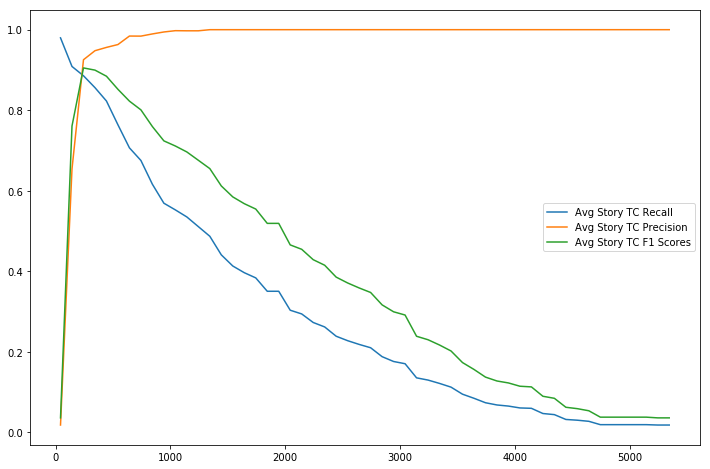

Max F1 Score: 0.9051
Optimal N Clusters: 243
CPU times: user 2.64 s, sys: 55.3 ms, total: 2.69 s
Wall time: 2.75 s


In [268]:
%%time
max_avg_story_tc_f1_scores, optimal_n_clusters = (
    gen_ac_tradeoff(ac_result, corpus_plus, training_cluster_ids_and_n_texts, plot=True)
)

In [269]:
%%time
summarize_ac(ac_result, optimal_n_clusters, corpus_plus, query='kavanaugh')

***** Cluster counts: *****
10597    2034
10587    1516
10573     195
10590     107
10553     105
10593      87
10582      86
10561      78
10563      56
10440      46
10507      43
10202      36
10586      36
10541      35
10585      29
10500      27
10588      26
10564      26
10591      26
10533      25
10493      25
10592      25
10580      24
10551      24
10430      22
10425      22
10547      20
10574      20
10594      17
10598      16
         ... 
4695        1
601         1
4723        1
2692        1
677         1
4839        1
4851        1
2832        1
825         1
2880        1
4959        1
4971        1
917         1
3124        1
950         1
5183        1
5399        1
3504        1
1665        1
3840        1
1981        1
1759        1
54          1
90          1
166         1
4312        1
218         1
2267        1
862         1
2037        1
Name: cluster, Length: 243, dtype: int64



***** Small clusters info: *****
Cluster Size 1: 94 records
Cluster Size 2

Sen. Klobuchar reacts to Kavanaugh's testimony
Sen. Klobuchar reacts to Kavanaugh's testimony
Kavanaugh Accuser Lied About Background, Has History Of Making Sexual Misconduct Claims In Workplace, Report Says
Lindsey Graham wants to investigate Senate Democrats who drew attention to Kavanaugh accusations
Christine Blasey Ford spurred a woman to name her alleged rapist: A state senator, who denies it
White House questioned over scope of FBI’s investigation into Kavanaugh
Christine Blasey Ford has not been contacted by FBI yet in Brett Kavanaugh investigation: Source
Christine Blasey Ford hasn't heard from FBI agents investigating Kavanaugh claims, lawyer says
Trump says he and Kim Jong Un ‘fell in love,’ praises relationship with North Korea
Trump denies restricting FBI investigation into Brett Kavanaugh sexual assault allegations
Trump denies restricting FBI investigation into Brett Kavanaugh sexual assault allegations
FBI spoke with Deborah Ramirez, second Kavanaugh accuser
Democrats D

Sanders releases video comparing Kavanaugh's and Trump's response to sexual assault claims
Trump 'wants FBI to interview' Julie Swetnick in Brett Kavanaugh investigation
Trump addresses Kavanaugh controversy: 'We don't want to go on a witch hunt, do we?'
Trump says FBI investigation should be "comprehensive"
Donald Trump ‘furious’ over Kavanaugh delay
Trump says he wants 'comprehensive' FBI investigation of Kavanaugh
Trump says he wants 'comprehensive' FBI investigation of Kavanaugh
Trump defends Kavanaugh during trade speech, says he wants ‘comprehensive’ FBI probe
Trump defends Kavanaugh during trade speech, says he wants ‘comprehensive’ FBI probe
Trump defends Kavanaugh during trade speech, says he wants ‘comprehensive’ FBI probe
Trump says he wants 'comprehensive' FBI investigation of Kavanaugh
Trump on Kavanaugh controversy: 'We don't want to go on a witch hunt, do we?' Video
Trump says FBI should interview "anybody they want" in Kavanaugh review
Trump says FBI should interview "a

The Burden Lies With Judge Kavanaugh
The unspoken reason Christine Blasey Ford may be viewed differently than Anita Hill
Christine Blasey Ford Reaches Deal to Testify at Kavanaugh Hearing
Trump: Michael Avenatti is a 'lowlife'
Tensions Rise as Kavanaugh Senate Hearing Nears
Clarence Thomas had another accuser — and she's worried about Kavanaugh's accusers
The Burden Lies With Judge Kavanaugh
For Judge Kavanaugh, It Must Be V For Victory
Trump court nominee Kavanaugh denies accusation by third woman
Obama-Era Campus Sex Rules ‘Playing Out on National Stage' with Kavanaugh
Trump court nominee Kavanaugh denies accusation by third woman
Trump court nominee Kavanaugh denies accusation by third woman
Christine Blasey Ford's attorney's release polygraph results on Kavanaugh allegations
Who is Deborah Ramirez, the second Kavanaugh accuser?
Trump set for rare news conference amid Kavanaugh, Rosenstein swirl
How To Watch The Brett Kavanaugh-Christine Blasey Ford Senate Hearing
Kavanaugh accuser 

Democrat apologizes for fundraising off Kavanaugh allegations
Fox News Host Says Christine Blasey Ford Testimony Is 'Disaster for Republicans,’ Says It's ‘Extremely Credible’
Fox News Host Says Christine Blasey Ford Testimony Is 'Disaster for Republicans,’ Says It's ‘Extremely Credible’
Each Year, They Gather For Anita Hill. Now They’re Ready For Christine Blasey Ford.
Rabbis discuss the Kavanaugh allegations
Kavanaugh Hearing Live Updates: Christine Blasey Ford Is ‘100%’ Certain Assailant Was Kavanaugh
Anita Hill cited again and again as Kavanaugh-Ford hearing opens
Trump’s Allies Don’t Think The Christine Blasey Ford Hearing Is Going Well For Brett Kavanaugh
Trump's favorite TV network deems Christine Blasey Ford testimony 'compelling'
Toobin on Kavanaugh accuser: 'Sickening' that 'anyone could consider this false testimony'
Christine Blasey Ford: Mark Judge Saw Me And Looked 'Ill' After Alleged Assault
Lindsey Graham Dismisses Two Men Who Claim They Assaulted Christine Blasey Ford
R

Shapiro On Fox News: Here's How The Democrats Will Handle The Kavanaugh FBI Investigation
FBI interviews Kavanaugh accuser as battle rages over scope of investigation
FBI interviews Kavanaugh accuser as battle rages over scope of investigation
Brett Kavanaugh confirmation – LIVE: Senate to consider Trump Supreme Court nomination amid sexual assault allegations
Another Trump coverup? Former FBI agents question limits on probe of Kavanaugh.
Brett Kavanaugh: Dr Christine Ford not on list of interview subjects for FBI sexual assault investigation
Amy Klobuchar's star turn in the Brett Kavanaugh confirmation hearings
Amy Klobuchar's star turn in the Brett Kavanaugh confirmation hearings
READ: Yale classmate's full statement on Kavanaugh
Donald Trump Jr. Says Brett Kavanaugh Hearing Has Him Fearing For His Sons
Hillary Clinton to headline first public campaign event of 2018
The White House is doing all it can to stop the FBI looking into Kavanaugh
Melania Trump forges ahead as first lady wit

UK foreign minister says Russia may wonder if Skripal poisoning was smart
Woman details sexual assault allegation against Trump court nominee
Woman details sexual assault allegation against Trump court nominee
US immigrants stop using public benefits over fears of new Trump rule
Economists Pessimistic With Brazil’s Presidential Election Outcome
Raw Politics: stark warnings that Europe could end up back to where it was in the 1930s
Trump court nominee's accuser says she feared being raped, killed
Trump court nominee's accuser says she feared being raped, killed
Trump court nominee's accuser says she feared being raped, killed
Opinion | What Readers Want to Ask Kavanaugh
Laughing With Him or at Him? New Zealand's Leader Tactfully Addresses President Trump's Viral U.N. Moment
Laughing With Him or at Him? New Zealand's Leader Tactfully Addresses President Trump's Viral U.N. Moment
The Worst Thing About Trump's Press Conference: It Was Business as Usual
The Worst Thing About Trump's Press C

In [264]:
%%time
ac_result = agglomerative_cluster(
    lemmatized_texts_embeddings,                   
    method='average', 
    metric='cityblock', 
    optimal_ordering=False
)

CPU times: user 5.68 s, sys: 65.1 ms, total: 5.75 s
Wall time: 5.76 s


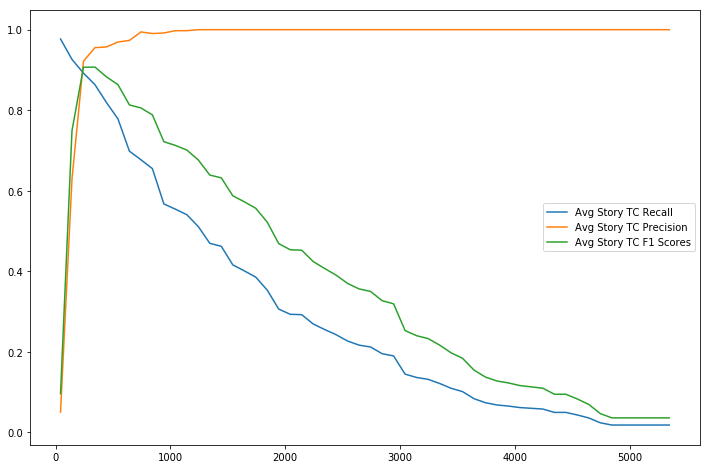

Max F1 Score: 0.9071
Optimal N Clusters: 343
CPU times: user 2.14 s, sys: 34.5 ms, total: 2.18 s
Wall time: 2.19 s


In [265]:
%%time
max_avg_story_tc_f1_scores, optimal_n_clusters = (
    gen_ac_tradeoff(ac_result, corpus_plus, training_cluster_ids_and_n_texts, plot=True)
)

In [266]:
%%time
summarize_ac(ac_result, optimal_n_clusters, corpus_plus, query='kavanaugh')

***** Cluster counts: *****
10494    1842
10500    1091
10478     197
10449     149
10307     103
10260     102
10488      91
10487      83
10282      78
10471      61
10444      54
10482      51
10457      46
10491      45
10496      37
10391      36
10093      35
10413      33
10481      30
10498      29
10412      28
10465      25
10043      25
10407      24
9880       24
10466      24
10411      23
10415      23
10410      23
10493      22
         ... 
4501        1
491         1
4621        1
2654        1
631         1
4159        1
799         1
4905        1
601         1
2692        1
5359        1
677         1
1209        1
3180        1
3124        1
5155        1
917         1
909         1
4971        1
4959        1
861         1
2880        1
825         1
2848        1
4895        1
2832        1
4851        1
4839        1
681         1
1981        1
Name: cluster, Length: 343, dtype: int64



***** Small clusters info: *****
Cluster Size 1: 140 records
Cluster Size 

Analysis: A look into the FBI probe of Kavanaugh Video
3rd Brett Kavanaugh accuser Julie Swetnick has history of legal disputes
New questions emerge over FBI investigation of Kavanaugh
Supreme Court begins new term in shadow of Kavanaugh fight
Yale classmate says Kavanaugh has "not told the truth" about his drinking
McConnell attacks credibility of Kavanaugh accuser Julie Swetnick
Flake says if FBI investigation finds Kavanaugh lied, nomination is over
Predictions of 'Kavanaugh Wave'--But for Which Party?
The Insanity of the Effort to Destroy Kavanaugh
Ben Shapiro Details Senate Democrats' Hypocrisy On Kavanaugh FBI Investigation
FBI Must Investigate Christine Blasey Ford's Credibility
Confirm Kavanaugh: End This Disgraceful Farce
Shapiro On Fox News: Here's How The Democrats Will Handle The Kavanaugh FBI Investigation
FBI interviews Kavanaugh accuser as battle rages over scope of investigation
FBI interviews Kavanaugh accuser as battle rages over scope of investigation
National Sexual

Trump says Republicans should have pushed through Kavanaugh sooner
Trump says Republicans should have pushed through Kavanaugh sooner
Trump says Republicans should have pushed through Kavanaugh sooner
Trump would prefer faster Brett Kavanaugh confirmation
Trump would prefer faster Brett Kavanaugh confirmation
Trump would prefer faster Brett Kavanaugh confirmation
Brett Kavanaugh provides high school calendar to Judiciary Committee
Kavanaugh accuser has four affidavits backing her assault claim
Donald Trump Says GOP Should Have Pushed Through Brett Kavanaugh's Vote 2 Weeks Ago
Senate Republicans just made a desperate move to avoid disaster in the Kavanaugh hearing
Michael Avenatti identifies Kavanaugh accuser as Julie Swetnick
Senate Republicans just made a desperate move to avoid disaster in the Kavanaugh hearing
Kavanaugh accuser has four affidavits backing her assault claim
Julie Swetnick Revealed As Michael Avenatti's Client Accusing Brett Kavanaugh Of Sexual Misconduct
Lawyer ident

Kavanaugh foes keep pressure on Collins, and her key vote
'My White House will do what senators want,' says Trump of Kavanaugh – video
Rep. Keith Ellison Abuse Claims Unsubstantiated, DFL-Hired Attorney Finds
Trump approves FBI expansion of Kavanaugh background check
Trump approves FBI expansion of Kavanaugh background check
Why Blasey's And Kavanaugh's Testimony Resonated Personally For Many Americans
Jeff Flake says it does no good to have an FBI investigation ‘that just gives more cover’ on Kavanaugh allegations
Supreme court begins new term without Brett Kavanaugh
Republicans think Kavanaugh is energizing their base. He’s also energizing the opposition.
Senate Democrats request FBI probe three separate allegations against Kavanaugh
FBI can interview anyone it deems relevant in Kavanaugh probe, White House says
FBI can interview anyone it deems relevant in Kavanaugh probe, White House says
FBI can interview anyone it deems relevant in Kavanaugh probe, White House says
Kavanaugh inqu

# Sklearn Agglomerative Clustering Method

In [ ]:
import itertools

def gen_ac_nodes(ac_model):
    ii = itertools.count(ac_model.n_leaves_)
    ac_nodes = [
        {'idx': next(ii), 
         'left_child': int(x[0]), 
         'right_child': int(x[1])} 
        for x in ac_model.children_
    ]
    
    return ac_nodes

def gen_ac_tradeoff(ac_model, docs, story_ids_and_n_docs, nodes_to_process_between_plots=100, plot=False):
    docs_ = docs.copy()
    n_docs = len(docs_)
    
    ac_nodes = gen_ac_nodes(ac_model)
    
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)
    
    n_clusters = []
    avg_story_tc_recalls = []
    avg_story_tc_precisions = []
    avg_story_tc_f1_scores = []
    
    for node in tqdm_notebook(ac_nodes):
        idx = node['idx']
        lc = node['left_child']
        rc = node['right_child']

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]
        
        for doc_id in cluster_doc_ids[idx]:
            doc_clusters[doc_id] = idx
        docs_['cluster'] = doc_clusters
        
        if idx % nodes_to_process_between_plots == 0:
            cluster_counts = docs_['cluster'].value_counts()

            story_tc_recalls = []
            story_tc_precisions = []
            story_weights = []
            for story_id, doc_count in story_ids_and_n_docs.items():
                filt = (docs_['training_cluster_id'] == story_id)
                story_cluster_counts = docs_[filt]['cluster'].value_counts()

                top_cluster_recall = story_cluster_counts.values[0] * 1.0 / doc_count
                top_cluster_precision = (
                    story_cluster_counts.values[0] * 1.0 / cluster_counts[story_cluster_counts.index[0]]
                )

                story_tc_recalls.append(top_cluster_recall)
                story_tc_precisions.append(top_cluster_precision)
                story_weights.append(doc_count)

            avg_story_tc_recall = np.average(story_tc_recalls, weights=story_weights)
            avg_story_tc_precision = np.average(story_tc_precisions, weights=story_weights)

            n_clusters.append(len(cluster_doc_ids))
            avg_story_tc_recalls.append(avg_story_tc_recall)
            avg_story_tc_precisions.append(avg_story_tc_precision)
            avg_story_tc_f1_scores.append(2.0/(1.0/avg_story_tc_recall + 1.0/avg_story_tc_precision))
        
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(n_clusters, avg_story_tc_recalls, label='Avg Story TC Recall')
        plt.plot(n_clusters, avg_story_tc_precisions, label='Avg Story TC Precision')
        plt.plot(n_clusters, avg_story_tc_f1_scores, label='Avg Story TC F1 Scores')
        plt.legend(loc='best')
        plt.show()
        plt.close()
    
    max_avg_story_tc_f1_scores = max(avg_story_tc_f1_scores)
    optimal_n_clusters = n_clusters[avg_story_tc_f1_scores.index(max_avg_story_tc_f1_scores)]
    
    print('Max F1 Score: %0.4f' % max_avg_story_tc_f1_scores)
    print('Optimal N Clusters: %s' % optimal_n_clusters)
    
    return max_avg_story_tc_f1_scores, optimal_n_clusters
    
    
def gen_cluster_labels(ac_model, n_clusters):
    n_docs = ac_model.n_leaves_
    ac_nodes = gen_ac_nodes(ac_model)    
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)
    
    for node in ac_nodes:
        idx = node['idx']
        lc = node['left_child']
        rc = node['right_child']

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]
        
        if len(cluster_doc_ids) == n_clusters:
            break

    for cluster_id, doc_ids in cluster_doc_ids.items():
        for doc_id in doc_ids:
            doc_clusters[doc_id] = cluster_id
            
    return doc_clusters


def summarize_ac(ac_model, n_clusters, docs, query='trump'):
    docs_ = docs.copy()
    n_docs = len(docs_)
    docs_['cluster'] = gen_cluster_labels(ac_model, n_clusters)

    cluster_counts = docs_['cluster'].value_counts()
    largest_cluster = cluster_counts.index[0]
    
    print('***** Cluster counts: *****')
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Small clusters info: *****')
    small_cluster_records = 0
    for i in np.arange(1, 6):
        records = (sum(docs_['cluster'].value_counts() == i)*i)
        print('Cluster Size %d: %d records' % (i, records))
        small_cluster_records += records
    pct_small_cluster_records = small_cluster_records/n_docs
    print('Pct Records in Small Clusters: %0.3f' % pct_small_cluster_records)
    
    print('\n' * 2)
    print('***** Largest cluster headlines: *****')
    for item in docs_[docs_['cluster'] == largest_cluster]['title']:
        print(item)
    
    filt = docs_['title'].apply(lambda x: query in x.lower())
    cluster_counts = docs_[filt]['cluster'].value_counts()
    print('\n' * 2)
    print('***** %s cluster counts: *****' % query)
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[0]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 2nd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[1]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 3rd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[2]]['title']:
        print(item)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
%%time
ac_model = AgglomerativeClustering(
    affinity='manhattan',
    linkage='average',
)

In [ ]:
%%time
ac_model.fit(lemmatized_texts_embeddings)

In [ ]:
max_avg_story_tc_f1_scores, optimal_n_clusters = (
    gen_ac_tradeoff(ac_model, corpus_plus, training_cluster_ids_and_n_texts, plot=True)
)

In [ ]:
summarize_ac(ac_model, optimal_n_clusters, corpus_plus, query='kavanaugh')

## SparseHC-Inspired Method

SparseHC Paper: https://www.sciencedirect.com/science/article/pii/S1877050914001781

In [ ]:
from clustering import LinearAC

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from collection import get_cluster_training_corpus
# from utils import gen_text_embeddings, vectors_and_vocab
    

def plot_ac_tradeoff(texts, clusters, training_cluster_ids_and_n_texts,
                     nodes_to_process_between_plots=100):
    """
    
    Keyword arguments:
    
    """
    texts_ = texts.copy()
    size = len(texts_)

    cluster_obs = {}
    for i in np.arange(0, size):
        cluster_obs[i] = [i]
    
    cluster_labels = np.arange(0, size)
    
    cluster_id = size * 1 

    n_clusters = []
    avg_training_cluster_recalls = []
    avg_training_cluster_precisions = []
    avg_training_cluster_f1_scores = []

    for child_pair in tqdm_notebook(clusters):
        child_0 = child_pair[0]
        child_1 = child_pair[1]
        if((child_0 == -1) or (child_1 == -1)):
            continue
        
        cluster_obs[cluster_id] = cluster_obs[child_0] + cluster_obs[child_1]
        del cluster_obs[child_0]
        del cluster_obs[child_1]

        for obs in cluster_obs[cluster_id]:
            cluster_labels[obs] = cluster_id
        
        cluster_id += 1
        
        if cluster_id % nodes_to_process_between_plots == 0:
            texts_['cluster'] = cluster_labels
            cluster_counts = texts_['cluster'].value_counts()

            training_cluster_recalls = []
            training_cluster_precisions = []
            training_cluster_weights = []
            for training_cluster_id, text_count in training_cluster_ids_and_n_texts.items():
                filt = (texts_['training_cluster_id'] == training_cluster_id)
                training_cluster_counts = texts_[filt]['cluster'].value_counts()

                top_cluster_recall = training_cluster_counts.values[0] * 1.0 / text_count
                top_cluster_precision = (
                    training_cluster_counts.values[0] * 1.0 / cluster_counts[training_cluster_counts.index[0]]
                )

                training_cluster_recalls.append(top_cluster_recall)
                training_cluster_precisions.append(top_cluster_precision)
                training_cluster_weights.append(text_count)

            avg_training_cluster_recall = np.average(training_cluster_recalls, weights=training_cluster_weights)
            avg_training_cluster_precision = np.average(training_cluster_precisions, weights=training_cluster_weights)

            n_clusters.append(len(cluster_obs))
            avg_training_cluster_recalls.append(avg_training_cluster_recall)
            avg_training_cluster_precisions.append(avg_training_cluster_precision)
            avg_training_cluster_f1_scores.append(2.0/(1.0/avg_training_cluster_recall + 1.0/avg_training_cluster_precision))

    plt.figure(figsize=(12, 8))
    plt.plot(n_clusters, avg_training_cluster_recalls, label='Avg Training Cluster Recall')
    plt.plot(n_clusters, avg_training_cluster_precisions, label='Avg Training Cluster Precision')
    plt.plot(n_clusters, avg_training_cluster_f1_scores, label='Avg Training Cluster F1 Score')
    plt.legend(loc='best')
    plt.show()
    plt.close()

    print('Max F1 Score: %0.4f' % max(avg_training_cluster_f1_scores))

In [ ]:
test_linear_ac = LinearAC(lemmatized_texts_embeddings)

In [ ]:
%%time
test_linear_ac.fit()

In [ ]:
plot_ac_tradeoff(corpus_plus, test_linear_ac.children, training_cluster_ids_and_n_texts)

## DBSCAN Method

In [ ]:
import DBSCAN_multiplex as DB

In [ ]:
# minpts_to_try = [3, 10, 25, 100]
# quantiles_to_try = [10, 25, 50, 75, 90]
minpts_to_try = [10]
quantiles_to_try = [50]

In [ ]:
minpts_ = []
quantiles_ = []
avg_training_cluster_recalls = []
avg_training_cluster_precisions = []
avg_training_cluster_f1_scores = []

for minpts in minpts_to_try:
    for quantile in quantiles_to_try:
        eps, labels_matrix = DB.DBSCAN(lemmatized_texts_embeddings, minPts=minpts, quantile=quantile, verbose=False)
        cluster_labels = labels_matrix[0]
        texts_['cluster'] = cluster_labels
        cluster_counts = texts_['cluster'].value_counts()

        training_cluster_recalls = []
        training_cluster_precisions = []
        training_cluster_weights = []
        for training_cluster_id, text_count in training_cluster_ids_and_n_texts.items():
            filt = (texts_['training_cluster_id'] == training_cluster_id)
            training_cluster_counts = texts_[filt]['cluster'].value_counts()

            top_cluster_recall = training_cluster_counts.values[0] * 1.0 / text_count
            top_cluster_precision = (
                training_cluster_counts.values[0] * 1.0 / cluster_counts[training_cluster_counts.index[0]]
            )

            training_cluster_recalls.append(top_cluster_recall)
            training_cluster_precisions.append(top_cluster_precision)
            training_cluster_weights.append(text_count)

        avg_training_cluster_recall = np.average(training_cluster_recalls, weights=training_cluster_weights)
        avg_training_cluster_precision = np.average(training_cluster_precisions, weights=training_cluster_weights)

        minpts_.append(minpts)
        quantiles_.append(quantile)
        avg_training_cluster_recalls.append(avg_training_cluster_recall)
        avg_training_cluster_precisions.append(avg_training_cluster_precision)
        avg_training_cluster_f1_scores.append(2.0/(1.0/avg_training_cluster_recall + 1.0/avg_training_cluster_precision))

# plt.figure(figsize=(12, 8))
# plt.plot(n_clusters, avg_training_cluster_recalls, label='Avg Training Cluster Recall')
# plt.plot(n_clusters, avg_training_cluster_precisions, label='Avg Training Cluster Precision')
# plt.plot(n_clusters, avg_training_cluster_f1_scores, label='Avg Training Cluster F1 Score')
# plt.legend(loc='best')
# plt.show()
# plt.close()

# print('Max F1 Score: %0.4f' % max(avg_training_cluster_f1_scores))